# MLS - RAG


## Recap

### Retrieval-Augmented Generation (RAG)

An important application of LLMs is enabling users to query unstructured data in natural language. This is finding a lot of traction in industries where the data is naturally unstructured in nature (e.g., finance, healthcare). The figure below shows how the finance sector is utilizing LLMs to query and summarize documents.

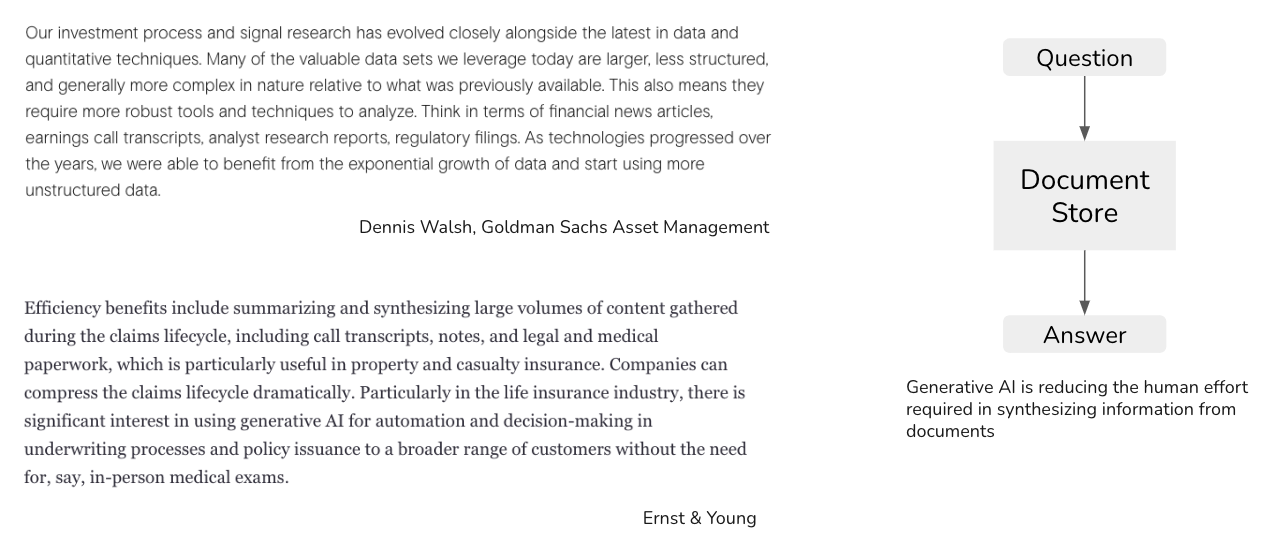

### RAG Building Blocks

#### A workflow for RAG

The figure below depicts the key stages involved in designing a RAG solution using LLMs. Let us look at each stage in detail.

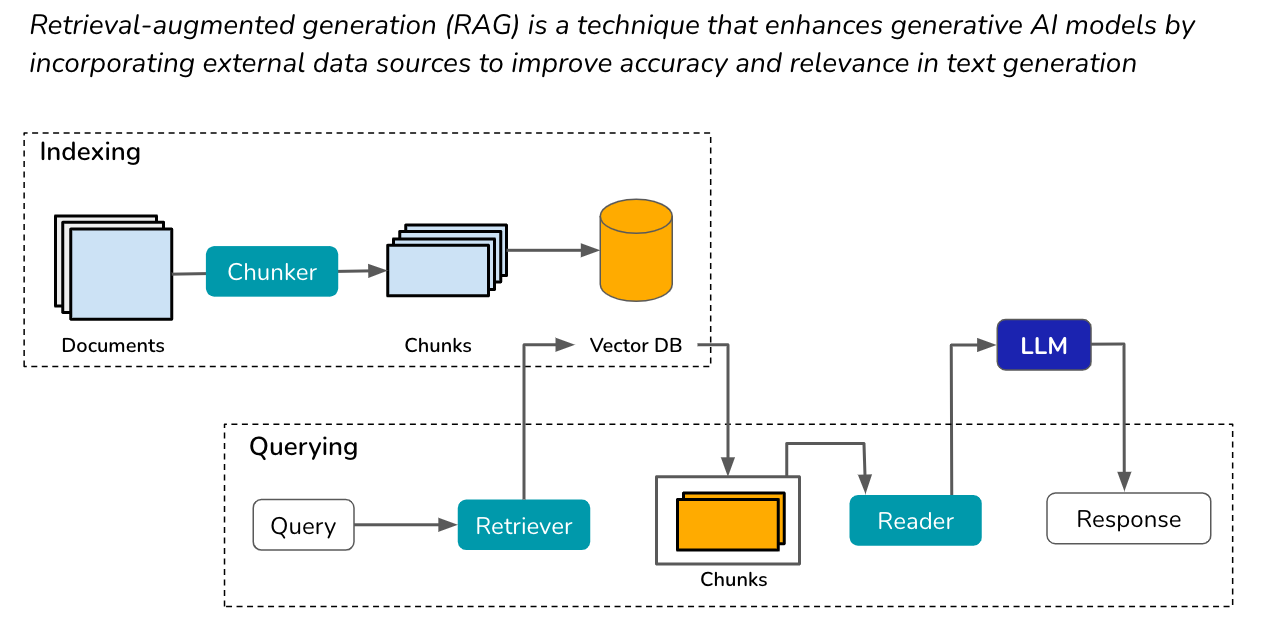

#### Step 1: Creating a Vector Database (Indexing)

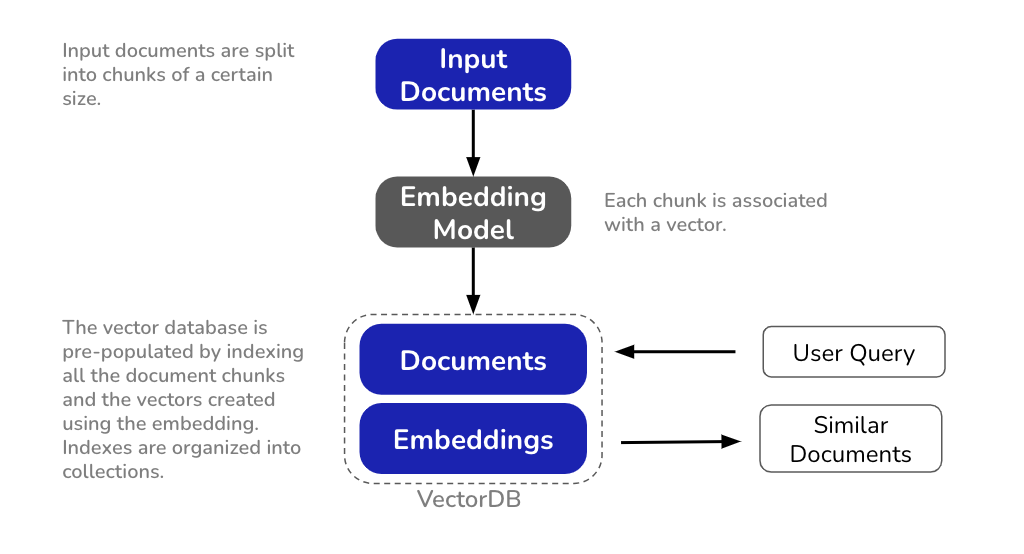

As the above figure indicates, there are two important components of vector database creation that merit a deeper look - choice of embedding model and chunking.

### Choosing an embedding model

As we have established in our LVC, [`gte-large`](https://huggingface.co/thenlper/gte-large) is a good general purpose embedding model.

### Chunking documents

Once the choice of embedding model is made, we can feed the input documents to the model. However, since there are multiple pages across documents (including figures, tables) we will need a method to parse individual portions of the document that is aligned with the embedding model.

We also know that the embedding model cannot process text beyond a fixed context length (512 tokens for `gte-large`). This roughly corresponds to about 400 words or about 1 page of text. With this limitation in mind, we will transform the pdf file into chunks of text that are no more than 512 chunks long. An alternative method would be to chunk the file by sections in the report (e.g., risk factors, legal proceedings, safety disclosures).

A common chunking strategy is to used a fixed-size chunk as defined by the embedding model and use a small overlap between the chunks (see figure below).


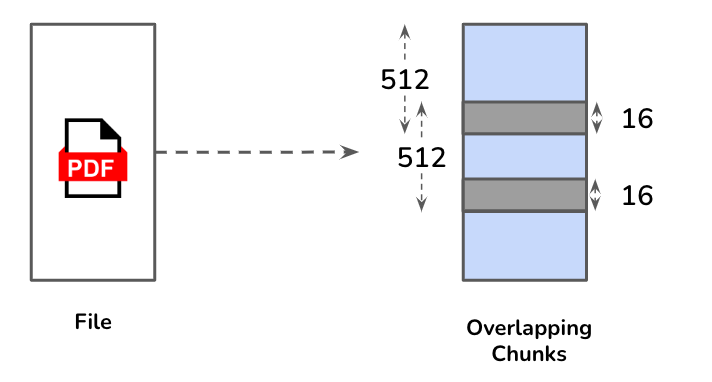

Using an overlap allows for continuity between chunks and retrieval of relevant chunks even when the information relevant to the query is present either at the beginning of the chunk or the end of the chunk.

### Creating a persistent vector database

### Step 2: Querying the Vector Database

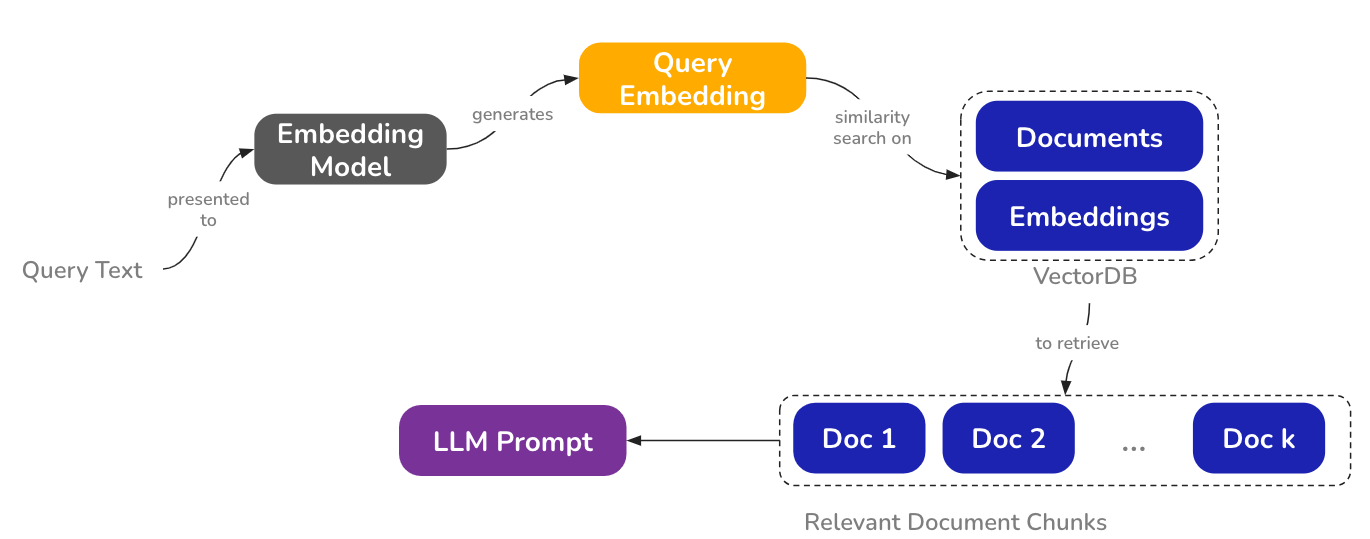

## Business Use Case

**Business Scenario: Enhancing Product Adoption through RAG Chatbot**

In today's rapidly evolving AI community, the introduction of numerous new libraries is accompanied by extensive documentation on their usage. For innovative companies like LangChain and LlamaIndex, it is crucial to ensure widespread adoption of their products by developers. This adoption directly drives their business growth. One effective strategy to increase adoption is to simplify the use of their libraries.

A valuable tool to support this initiative is a chatbot capable of answering questions about the product. While large language models (LLMs) can sometimes generate inaccurate information (a phenomenon known as hallucination), this issue can be mitigated through Retrieval-Augmented Generation (RAG). RAG enhances LLMs by providing them with current, factual information.

**Today's Objective**

Our goal today is to develop a chatbot for Streamlit Documentation that assists users by answering questions about using streamlit replicating the chatbot feature on LangChain. To ensure the development can be completed within our session, we will implement this on a sample of Streamlit documentation consisting of 298 documents.

This project involves:
1. Integrating RAG to enhance the accuracy of the chatbot.
2. Testing the chatbot's performance on a selected subset of queries.

By successfully implementing this chatbot, we aim to provide a tool that simplifies the user experience, thereby driving higher adoption rates for Streamlit.

We will perform this in two steps like we have done in our previous MLS. However, this time we are going to do it in a single notebook.

First we will create the vector database with document embeddings and store it on Gdrive.

In the second stage, we will load the database from Gdrive, perfrom querying and then rate our RAG using a larger model.


For the first part, use a T4 GPU and for the second part you can switch to a CPU.

**Connect to a T4 GPU Instance.**

### Setup

In [1]:
!pip install -q openai==1.23.2 \
                tiktoken==0.6.0 \
                langchain==0.1.1 \
                langchain-community==0.0.13 \
                chromadb==0.4.22 \
                sentence-transformers==2.3.1 \
                datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.4/802.4 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [2]:
import json
import tiktoken
from datasets import load_dataset

import pandas as pd

from openai import OpenAI

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings
)
from langchain_community.vectorstores import Chroma

from google.colab import userdata, drive

## Impementing RAG

## Assemble Vector Database (One-time Setup)

### Download and Prepare Data

Let's start by loading the dataset.

In [3]:
docs = load_dataset("sai-lohith/streamlit_docs")

Generating train split:   0%|          | 0/298 [00:00<?, ? examples/s]

In [4]:
docs = docs['train'].to_pandas()

In [5]:
docs.shape

(298, 2)

In [6]:
docs.head()

Link  \
0  https://docs.streamlit.io/develop/api-referenc...   
1  https://docs.streamlit.io/deploy/streamlit-com...   
2  https://docs.streamlit.io/en/0.74.0/api.html#d...   
3  https://docs.streamlit.io/develop/api-referenc...   
4  https://docs.streamlit.io/develop/api-referenc...   

                                                Text  
0  DocumentationsearchSearchrocket_launchGet star...  
1  DocumentationsearchSearchrocket_launchGet star...  
2  DocumentationsearchSearchrocket_launchGet star...  
3  DocumentationsearchSearchrocket_launchGet star...  
4  DocumentationsearchSearchrocket_launchGet star...

Let's check one of the documents to understand what we are working with.

In [7]:
print(docs.iloc[3,1])

DocumentationsearchSearchrocket_launchGet startedInstallationaddFundamentalsaddFirst stepsaddcodeDevelopConceptsaddAPI referenceremovePAGE ELEMENTSWrite and magicaddText elementsaddData elementsaddChart elementsaddInput widgetsaddMedia elementsaddLayouts and containersaddChat elementsaddStatus elementsaddThird-party componentsopen_in_newAPPLICATION LOGICNavigation and pagesaddExecution flowaddCaching and stateaddConnections and secretsaddCustom componentsaddUtilitiesaddConfigurationaddTOOLSApp testingremovest.testing.v1.AppTestTesting element classesCommand lineaddTutorialsaddQuick referenceaddweb_assetDeployConceptsaddStreamlit Community CloudaddStreamlit in Snowflakeopen_in_newOther platformsaddschoolKnowledge baseFAQInstalling dependenciesDeployment issuesHome/Develop/API reference/App testing/Testing element classesTesting element classes
st.testing.v1.element_tree.Block
The Block class has the same methods and attributes as AppTest. A Block instance represents a container of eleme

It is long document. Let's do an analysis of the lengths of the docs.

Before that, we can observe that the first line of the document is useless. Let's check if this line is present in all documents. If so, let's remove it.

In [8]:
docs['Text'] = docs['Text'].apply(lambda text: '\n'.join(text.split('\n')[1:]))

Let's check the number of tokens in each document.

We are going to use tiktoken as a proxy to count the number of tokens in each document. It uses OPENAI based encoding to ind out the number of token which is not the same as our encoding however, this works as a good proxy.

In [9]:
def token_count(text):

    """
    Return the number of tokens used by texts.
    Adapted from the Open AI cookbook token counter
    """

    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

    return len(encoding.encode(text))

In [10]:
docs['token_count'] = docs['Text'].apply(token_count)

Let's plot the number of token in each document to understand our dataset better.

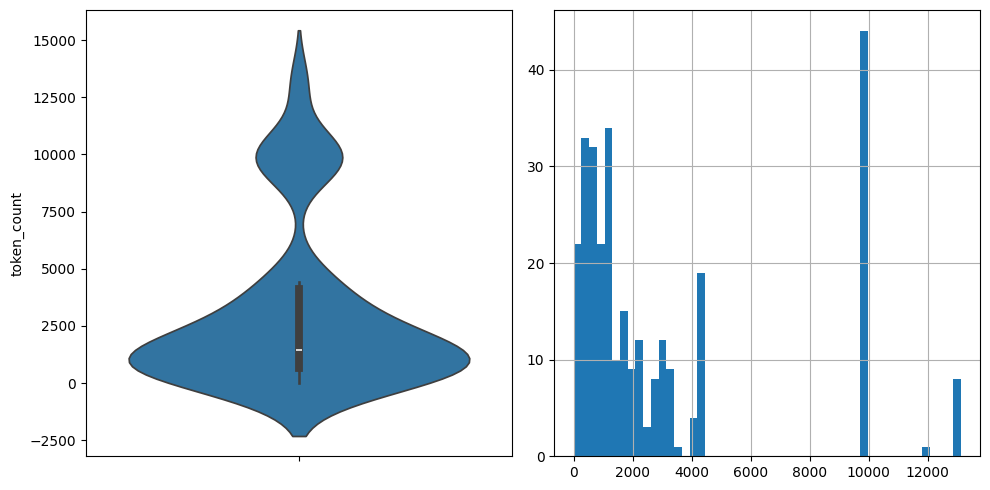

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create the violin plot on the first subplot
sns.violinplot(data=docs['token_count'], ax=axs[0])

# Create the histogram on the second subplot
docs['token_count'].hist(ax=axs[1], bins = 50)

# Display the plots
plt.tight_layout()
plt.show()

# Show the plot
plt.show()

We can see that most of our data has less than 1600 token count. With a chunk size of 1024, we will get roughly 1-3 chunks for a majority of the docs. However, we need to have a decent overlap so that context is maintained across chunks. Let's have an overlap of 50 tokens.



### Chunking

In [12]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',
    chunk_size=512,
    chunk_overlap=50
)

Let's create a splitter that will split and chunk using our chunking strategy. Each doc will be chunked into smaller parts however, all the individual chunks have the link from the same parent document.

In [13]:
new_data = []

for index, row in docs.iterrows():
    chunks = text_splitter.split_text(row['Text'])
    for chunk in chunks:
        new_data.append({'chunk': chunk, 'link': row['Link']})

chunks = pd.DataFrame(new_data)

In [14]:
chunks.shape

(2277, 2)

Our 298 docs have become 2277 docs now. Let's randomly look at few chunks.

In [15]:
chunks.head()

chunk  \
0  Streamlit supports several different charting ...   
1  Third-party componentsThese are featured compo...   
2  st_data = st_folium(m, width=725)\nSpacy-Strea...   
3  hip.Experiment.from_iterable(data).display()\n...   
4  Social media sites generate a card with a titl...   

                                                link  
0  https://docs.streamlit.io/develop/api-referenc...  
1  https://docs.streamlit.io/develop/api-referenc...  
2  https://docs.streamlit.io/develop/api-referenc...  
3  https://docs.streamlit.io/develop/api-referenc...  
4  https://docs.streamlit.io/deploy/streamlit-com...

In [16]:
chunks.iloc[23,0]

'Third-party componentsThese are featured components created by our lovely community. If you don\'t see what you\'re looking for, check out our Components Hub app and Streamlit Extras for more examples and inspiration!StqdmThe simplest way to handle a progress bar in streamlit app. Created by @Wirg.from stqdm import stqdm\n\nfor _ in stqdm(range(50)):\n    sleep(0.5)\nCustom notification boxA custom notification box with the ability to close it out. Created by @Socvest.from streamlit_custom_notification_box import custom_notification_box\n\nstyles = {\'material-icons\':{\'color\': \'red\'}, \'text-icon-link-close-container\': {\'box-shadow\': \'#3896de 0px 4px\'}, \'notification-text\': {\'\':\'\'}, \'close-button\':{\'\':\'\'}, \'link\':{\'\':\'\'}}\ncustom_notification_box(icon=\'info\', textDisplay=\'We are almost done with your registration...\', externalLink=\'more info\', url=\'#\', styles=styles, key="foo")\nStreamlit ExtrasA library with useful Streamlit extras. Created by @arn

### Database Creation

In [17]:
embedding_model_name='thenlper/gte-large'

In [18]:
embedding_model = SentenceTransformerEmbeddings(model_name=embedding_model_name)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [19]:
docs = [Document(page_content = doc, metadata = {"Link":link})for doc, link in zip(chunks['chunk'],chunks['link'])
                 ]

In [20]:
len(docs)

2277

In [21]:
print(docs[0])

page_content='Streamlit supports several different charting libraries, and our goal is to\ncontinually add support for more. Right now, the most basic library in our\narsenal is Matplotlib. Then there are also\ninteractive charting libraries like Vega\nLite (2D charts) and\ndeck.gl (maps and 3D charts). And\nfinally we also provide a few chart types that are "native" to Streamlit,\nlike st.line_chart and st.area_chart.\nSimple chart elements\nSimple area chartsDisplay an area chart.st.area_chart(my_data_frame)\nSimple bar chartsDisplay a bar chart.st.bar_chart(my_data_frame)\nSimple line chartsDisplay a line chart.st.line_chart(my_data_frame)\nSimple scatter chartsDisplay a line chart.st.scatter_chart(my_data_frame)\nScatterplots on mapsDisplay a map with points on it.st.map(my_data_frame)\n\nAdvanced chart elements\nMatplotlibDisplay a matplotlib.pyplot figure.st.pyplot(my_mpl_figure)\nAltairDisplay a chart using the Altair library.st.altair_chart(my_altair_chart)\nVega-LiteDisplay a 

In [22]:
documentation = Chroma.from_documents(
    docs,
    embedding_model,
    collection_name="streamlit",
    persist_directory='./streamlitdb'
)

In [23]:
documentation.persist()

Let's check the contents of the vectorDB

In [24]:
documentation.get()

{'ids': ['539fc44c-27a2-11ef-baed-0242ac1c000c',
  '539fc5b4-27a2-11ef-baed-0242ac1c000c',
  '539fc636-27a2-11ef-baed-0242ac1c000c',
  '539fc6a4-27a2-11ef-baed-0242ac1c000c',
  '539fc6fe-27a2-11ef-baed-0242ac1c000c',
  '539fc76c-27a2-11ef-baed-0242ac1c000c',
  '539fc7d0-27a2-11ef-baed-0242ac1c000c',
  '539fc82a-27a2-11ef-baed-0242ac1c000c',
  '539fc884-27a2-11ef-baed-0242ac1c000c',
  '539fc8e8-27a2-11ef-baed-0242ac1c000c',
  '539fc942-27a2-11ef-baed-0242ac1c000c',
  '539fc99c-27a2-11ef-baed-0242ac1c000c',
  '539fc9f6-27a2-11ef-baed-0242ac1c000c',
  '539fca82-27a2-11ef-baed-0242ac1c000c',
  '539fcaf0-27a2-11ef-baed-0242ac1c000c',
  '539fcb54-27a2-11ef-baed-0242ac1c000c',
  '539fcbae-27a2-11ef-baed-0242ac1c000c',
  '539fcc12-27a2-11ef-baed-0242ac1c000c',
  '539fcc6c-27a2-11ef-baed-0242ac1c000c',
  '539fccc6-27a2-11ef-baed-0242ac1c000c',
  '539fcd20-27a2-11ef-baed-0242ac1c000c',
  '539fcd84-27a2-11ef-baed-0242ac1c000c',
  '539fcdde-27a2-11ef-baed-0242ac1c000c',
  '539fce42-27a2-11ef-baed-

Let's create a retriever that fetches 5 responses for every query.

In [25]:
retriever = documentation.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)

Upload the current DB state to Google Drive, so we can avoid using GPU during querying.

In [26]:
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
!cp -r streamlitdb /content/drive/MyDrive/

Since the vector database state is saved, we no longer need the GPU. **Please switch to a CPU instance.**

# Part - 2

Let's setup the CPU instance

### Setup

In [28]:
!pip install -q openai==1.23.2 \
                tiktoken==0.6.0 \
                langchain==0.1.1 \
                langchain-community==0.0.13 \
                chromadb==0.4.22 \
                sentence-transformers==2.3.1

In [29]:
import json
import tiktoken

import pandas as pd

from openai import OpenAI

from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings
)
from langchain_community.vectorstores import Chroma

from google.colab import userdata, drive

In [30]:
anyscale_api_key = userdata.get('anyscale_api_key')

In [31]:
client = OpenAI(
    base_url="https://api.endpoints.anyscale.com/v1",
    api_key=anyscale_api_key
)

We are going to use Mixtral 8x7B model for this exercise due to it's higher performance.

In [32]:
model_name = 'mistralai/Mixtral-8x7B-Instruct-v0.1'

## Impementing RAG

## Load Vector DB from Google Drive

In [33]:
embedding_model_name='thenlper/gte-large'

In [34]:
embedding_model = SentenceTransformerEmbeddings(model_name=embedding_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [35]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Since we persisted the database to a Google Drive location, we can download the database to the instance using its unique id like so:

In [36]:
persisted_vectordb_location = '/content/drive/MyDrive/streamlitdb'

In practise, the database is maintained as a separate entity and CRUD operations are managed just as one would for normal databases (e.g., relational databases).

In [37]:
streamlitdb = Chroma(
    collection_name="streamlit",
    persist_directory=persisted_vectordb_location,
    embedding_function=embedding_model
)

In [38]:
streamlitdb.get() #Let's check if we have all the embeddings ready.

{'ids': ['539fc44c-27a2-11ef-baed-0242ac1c000c',
  '539fc5b4-27a2-11ef-baed-0242ac1c000c',
  '539fc636-27a2-11ef-baed-0242ac1c000c',
  '539fc6a4-27a2-11ef-baed-0242ac1c000c',
  '539fc6fe-27a2-11ef-baed-0242ac1c000c',
  '539fc76c-27a2-11ef-baed-0242ac1c000c',
  '539fc7d0-27a2-11ef-baed-0242ac1c000c',
  '539fc82a-27a2-11ef-baed-0242ac1c000c',
  '539fc884-27a2-11ef-baed-0242ac1c000c',
  '539fc8e8-27a2-11ef-baed-0242ac1c000c',
  '539fc942-27a2-11ef-baed-0242ac1c000c',
  '539fc99c-27a2-11ef-baed-0242ac1c000c',
  '539fc9f6-27a2-11ef-baed-0242ac1c000c',
  '539fca82-27a2-11ef-baed-0242ac1c000c',
  '539fcaf0-27a2-11ef-baed-0242ac1c000c',
  '539fcb54-27a2-11ef-baed-0242ac1c000c',
  '539fcbae-27a2-11ef-baed-0242ac1c000c',
  '539fcc12-27a2-11ef-baed-0242ac1c000c',
  '539fcc6c-27a2-11ef-baed-0242ac1c000c',
  '539fccc6-27a2-11ef-baed-0242ac1c000c',
  '539fcd20-27a2-11ef-baed-0242ac1c000c',
  '539fcd84-27a2-11ef-baed-0242ac1c000c',
  '539fcdde-27a2-11ef-baed-0242ac1c000c',
  '539fce42-27a2-11ef-baed-

Let's test our vectorDB with a test query.

In [39]:
query = "How to draw charts in streamlit"

In [40]:
docs = streamlitdb.similarity_search(query, k=5)

In [41]:
for i, doc in enumerate(docs):
    print(f"Retrieved chunk {i+1}: \n")
    print(doc.page_content.replace('\t', ' '))
    print("Source: ", doc.metadata['Link'],"\n ===================================================== \n")
    print('\n')

Retrieved chunk 1: 

This Get Started guide explains how Streamlit works, how to install Streamlit on your preferred
operating system, and how to create your first Streamlit app!
downloadingInstallation helps you set up your development environment. Walk through installing Streamlit on Windows, macOS, or Linux. Alternatively, code right in your browser with GitHub Codespaces or Streamlit in Snowflake.descriptionFundamentals introduces you to Streamlit's data model and development flow. You'll learn what makes Streamlit the most powerful way to build data apps, including the ability to display and style data, draw charts and maps, add interactive widgets, customize app layouts, cache computation, and define themes.auto_awesomeFirst steps walks you through creating apps using core features to fetch and cache data, draw charts, plot information on a map, and use interactive widgets to filter results.rocket_launchUse GitHub Codespaces if you want to skip past local installation and code ri

In [42]:
retriever = streamlitdb.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)

The vectorDB seems to work fine, let's move on to the next step.

## RAG Q&A

### Prompt Design

Let's formulate a prompt to fetch a Retrieval Augmented Generation from the LLM.

It is essential to ensure that the LLM does not generate hallucinated or random answers when faced with irrelevant information in the retrieved documents. Additionally, the LLM should provide the source of the information it offers. Including source citations will enhance the reliability and credibility of our chatbot.

In [43]:
qna_system_message = """
You are an assistant to a coder. Your task is to provide relevant information about the Python package Streamlit.

User input will include the necessary context for you to answer their questions. This context will begin with the token: ###Context.
The context contains references to specific portions of documents relevant to the user's query, along with source links.
The source for a context will begin with the token ###Source

When crafting your response:
1. Select only context relevant to answer the question.
2. Include the source links in your response.
3. User questions will begin with the token: ###Question.
4. If the question is irrelevant to streamlit respond with - "I am an assistant for streamlit Docs. I can only help you with questions related to streamlit"

Please adhere to the following guidelines:
- Your response should only be about the question asked and nothing else.
- Answer only using the context provided.
- Do not mention anything about the context in your final answer.
- If the answer is not found in the context, it is very very important for you to respond with "I don't know. Please check the docs @ 'https://docs.streamlit.io/'"
- Always quote the source when you use the context. Cite the relevant source at the end of your response under the section - Source:
- Do not make up sources. Use the links provided in the sources section of the context and nothing else. You are prohibited from providing other links/sources.

Here is an example of how to structure your response:

Answer:
[Answer]

Source:
[Source]
"""

In [44]:
qna_user_message_template = """
###Context
Here are some documents and their source links that are relevant to the question mentioned below.
{context}

###Question
{question}
"""

### Retrieving relevant documents

Let's test our RAG chatbot now.

In [45]:
user_input = "How to deploy my streamlit app using Docker on GCP?"

In [46]:
relevant_document_chunks = retriever.get_relevant_documents(user_input)

In [47]:
len(relevant_document_chunks)

5

### Composing the response

In [48]:
relevant_document_chunks = retriever.get_relevant_documents(user_input)
context_list = [d.page_content + "\n ###Source: " + d.metadata['Link'] + "\n\n " for d in relevant_document_chunks]

context_for_query = ". ".join(context_list)

prompt = [
    {'role':'system', 'content': qna_system_message},
    {'role': 'user', 'content': qna_user_message_template.format(
         context=context_for_query,
         question=user_input
        )
    }
]

try:
    response = client.chat.completions.create(
        model=model_name,
        messages=prompt,
        temperature=0
    )

    prediction = response.choices[0].message.content.strip()
except Exception as e:
    prediction = f'Sorry, I encountered the following error: \n {e}'

print(prediction)

To deploy your Streamlit app using Docker on Google Cloud Platform (GCP), follow these steps:

1. Install Docker Engine and gcloud CLI.

   - Install Docker Engine: Docker provides .deb and .rpm packages from many Linux distributions, including Debian and Ubuntu. Verify the installation by running the hello-world Docker image. Follow Docker's official post-installation steps for Linux to run Docker as a non-root user.
   - Install the gcloud CLI: Follow the official documentation to install the gcloud CLI and initialize it.

2. Create a Docker container.

   - Create a run.sh script with the command to start your Streamlit app.
   - Create a Dockerfile: Set the WORKDIR to a directory other than the root directory (e.g., /home/appuser) and use the run.sh script as the ENTRYPOINT.

3. Build a Docker image.

   - Put the run.sh and Dockerfile in the same folder and build the docker image: `docker build --platform linux/amd64 -t gcr.io/$GCP_PROJECT_ID/k8s-streamlit:test .`

4. Upload the D

In [49]:
print(context_for_query)

Introduction
So you have an amazing app and you want to start sharing it with other people, what do you do? You have a few options. First, where do you want to run your Streamlit app, and how do you want to access it?

On your corporate network - Most corporate networks are closed to the outside world. You typically use a VPN to log onto your corporate network and access resources there. You could run your Streamlit app on a server in your corporate network for security reasons, to ensure that only folks internal to your company can access it.
On the cloud - If you'd like to access your Streamlit app from outside of a corporate network, or share your app with folks outside of your home network or laptop, you might choose this option. In this case, it'll depend on your hosting provider. We have community-submitted guides from Heroku, AWS, and other providers.

Wherever you decide to deploy your app, you will first need to containerize it. This guide walks you through using Kubernetes to

We can see that the context provided to the chatbot has all the information provided in the response however it was not structured well. The response from the LLM is structured and provides sources of the information included in the response.

As a next step, we can also add the documents from community portal like stackoverflow where there are plenty of errors and their solutions posted. This will improve the chatbot further by giving it information on how to resolve errors. Post this users can copy paste their errors and expect to find solution for them. However, this is out of scope for our session. We encourage you to build on top of this notebook.

Let us now use the LLM-as-a-judge method to check the quality of the RAG system on two parameters - retrieval and generation. We illustrate this evaluation based on the answeres generated to the question from the previous section.

## Evaluation

In [50]:
model_name = 'mistralai/Mixtral-8x7B-Instruct-v0.1'

In [51]:
rater_model = "meta-llama/Meta-Llama-3-70B-Instruct"

In [52]:
groundedness_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context and includes ###Source while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
The answer should be derived only from the information presented in the context

Instructions:
1. First write down the steps that are needed to evaluate the answer as per the metric.
2. Give a step-by-step explanation if the answer adheres to the metric considering the question and context as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the answer using the evaluaton criteria and assign a score.
"""

In [53]:
relevance_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
Relevance measures how well the answer addresses the main aspects of the question, based on the context.
Consider whether all and only the important aspects are contained in the answer when evaluating relevance.

Instructions:
1. First write down the steps that are needed to evaluate the context as per the metric.
2. Give a step-by-step explanation if the context adheres to the metric considering the question as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the context using the evaluaton criteria and assign a score out of 5.
"""

In [54]:
user_message_template = """
###Question
{question}

###Context
{context}

###Answer
{answer}
"""

In [55]:
user_input = "What are the different charts that i can produce in streamlit?"

In [56]:
relevant_document_chunks = retriever.get_relevant_documents(user_input)

In [57]:
relevant_document_chunks = retriever.get_relevant_documents(user_input)
context_list = [d.page_content + "\n ###Source: " + d.metadata['Link'] + "\n\n " for d in relevant_document_chunks]

context_for_query = ". ".join(context_list)

prompt = [
    {'role':'system', 'content': qna_system_message},
    {'role': 'user', 'content': qna_user_message_template.format(
         context=context_for_query,
         question=user_input
        )
    }
]

response = client.chat.completions.create(
    model=model_name,
    messages=prompt,
    temperature=0
)

answer = response.choices[0].message.content.strip()

In [58]:
print(answer)

Answer:
Streamlit supports several types of charts, including simple area charts, simple bar charts, simple line charts, simple scatter charts, scatterplots on maps, and more advanced charts like Matplotlib, Altair, Vega-Lite, Plotly, Bokeh, PyDeck, and GraphViz charts.

Source:
<https://docs.streamlit.io/develop/api-reference/charts#chart-elements>
<https://docs.streamlit.io/en/0.76.0/api.html#utilities-and-user-info>
<https://docs.streamlit.io/en/latest/api.html#app-testing>


In [59]:
groundedness_prompt = [
    {'role':'system', 'content': groundedness_rater_system_message},
    {'role': 'user', 'content': user_message_template.format(
        question=user_input,
        context=context_for_query,
        answer=answer
        )
    }
]

In [60]:
response = client.chat.completions.create(
    model=rater_model,
    messages=groundedness_prompt,
    temperature=0
)

print(response.choices[0].message.content)

Here are the steps to evaluate the answer as per the metric:

**Step 1: Identify the question and context**
The question is "What are the different charts that I can produce in Streamlit?" and the context provides information about the different charting libraries supported by Streamlit, including Matplotlib, Vega Lite, deck.gl, and native Streamlit charts.

**Step 2: Analyze the answer**
The answer lists the different types of charts supported by Streamlit, including simple area charts, simple bar charts, simple line charts, simple scatter charts, scatterplots on maps, and more advanced charts like Matplotlib, Altair, Vega-Lite, Plotly, Bokeh, PyDeck, and GraphViz charts.

**Step 3: Check if the answer is derived only from the information presented in the context**
The answer is entirely derived from the information presented in the context. The context mentions the different charting libraries supported by Streamlit, and the answer lists the specific types of charts that can be produ

In [61]:
relevance_prompt = [
    {'role':'system', 'content': relevance_rater_system_message},
    {'role': 'user', 'content': user_message_template.format(
        question=user_input,
        context=context_for_query,
        answer=answer
        )
    }
]

In [62]:
response = client.chat.completions.create(
    model=rater_model,
    messages=relevance_prompt,
    temperature=0
)

print(response.choices[0].message.content)

Here are the steps to evaluate the context as per the metric:

**Step 1: Identify the main aspects of the question**
The main aspect of the question is to know the different types of charts that can be produced in Streamlit.

**Step 2: Analyze the context to identify the relevant information**
The context provides a comprehensive overview of the different charting libraries supported by Streamlit, including Matplotlib, Vega Lite, deck.gl, and native Streamlit charts like st.line_chart and st.area_chart. It also lists various chart types, such as simple area charts, simple bar charts, simple line charts, simple scatter charts, scatterplots on maps, and more advanced charts like Matplotlib, Altair, Vega-Lite, Plotly, Bokeh, PyDeck, and GraphViz charts.

**Step 3: Evaluate the relevance of the context to the question**
The context is highly relevant to the question, as it provides a detailed list of the different types of charts that can be produced in Streamlit.

**Step 4: Evaluate the e

Our RAG implementation seems to work fine. Now, let's test it over a larger selection of documents.

In [63]:
# List of queries
queries = [
    #remember some of the following questions might not have answers in the sampled documentation of streamlit!
    "How to install Streamlit?",
    "How to create a slider widget in Streamlit?",
    "How to display a dataframe in Streamlit?",
    "How to create a button in Streamlit?",
    "How to deploy a Streamlit app on Heroku?",
    "How to use Streamlit st.cache?",
    "How to upload a file in Streamlit?",
    "How to create a sidebar in Streamlit?",
    "How to plot a graph in Streamlit?",
    "How to handle session state in Streamlit?"
    #Let's also add some queries which are not relevant. Let's see if the model outputs "I Don't Know"
    "who is barack obama",
    "how to destroy my laptop",
    "how to use streamlit to conjure devils"
]
# DataFrame to store the results
df = pd.DataFrame(columns=['query', 'response', 'context', 'groundedness_evaluation', 'relevance_evaluation'])

for query in queries:


    relevant_document_chunks = retriever.get_relevant_documents(query)
    context_list = [d.page_content + "\n ###Source: " + d.metadata['Link'] + "\n\n " for d in relevant_document_chunks]

    context_for_query = ". ".join(context_list)

    prompt = [
        {'role':'system', 'content': qna_system_message},
        {'role': 'user', 'content': qna_user_message_template.format(
            context=context_for_query,
            question=query
            )
        }
    ]


    response = client.chat.completions.create(
        model=model_name,
        messages=prompt,
        temperature=0
    )

    answer = response.choices[0].message.content.strip()
    # print(context_for_query)
    # print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    # print(answer)
    # print("====================================================================")

    # Groundedness prompt
    groundedness_prompt = [
        {'role':'system', 'content': groundedness_rater_system_message},
        {'role': 'user', 'content': user_message_template.format(
            question=query,
            context=context_for_query,
            answer=answer
            )
        }
    ]

    # Get the groundedness response
    response = client.chat.completions.create(
        model=rater_model,
        messages=groundedness_prompt,
        temperature=0
    )
    groundedness_response = response.choices[0].message.content

    # Relevance prompt
    relevance_prompt = [
        {'role':'system', 'content': relevance_rater_system_message},
        {'role': 'user', 'content': user_message_template.format(
            question=query,
            context=context_for_query,
            answer=answer
            )
        }
    ]

    # Get the relevance response
    response = client.chat.completions.create(
        model=rater_model,
        messages=relevance_prompt,
        temperature=0
    )
    relevance_response = response.choices[0].message.content

    # Store the query and responses in the DataFrame
    df = pd.concat([df, pd.DataFrame([{'query': query,'response': answer, 'context': context_for_query, 'groundedness_evaluation': groundedness_response, 'relevance_evaluation': relevance_response}])], ignore_index=True)
df.head(13)

query  \
0                           How to install Streamlit?   
1         How to create a slider widget in Streamlit?   
2            How to display a dataframe in Streamlit?   
3                How to create a button in Streamlit?   
4            How to deploy a Streamlit app on Heroku?   
5                      How to use Streamlit st.cache?   
6                  How to upload a file in Streamlit?   
7               How to create a sidebar in Streamlit?   
8                   How to plot a graph in Streamlit?   
9   How to handle session state in Streamlit?who i...   
10                           how to destroy my laptop   
11             how to use streamlit to conjure devils   

                                             response  \
0   To install Streamlit, you can use pip, which i...   
1   To create a slider widget in Streamlit, you ca...   
2   To display a dataframe in Streamlit, you can u...   
3   To create a button in Streamlit, you can use t...   
4   To deploy a Streamlit app on Heroku, you need ...   
5   To use Streamlit's caching mechanism, you need...   
6   To upload a file in Streamlit, you can use the...   
7   To create a sidebar in Streamlit, you can use ...   
8   To plot a graph in Streamlit, you can use the ...   
9   To handle session state in Streamlit, you can ...   
10  I am an assistant for streamlit Docs. I can on...   
11  I am an assistant for Streamlit Docs. I can on...   

                                              context  \
0   This Get Started guide explains how Streamlit ...   
1   With widgets, Streamlit allows you to bake int...   
2   Dataframes are a great way to display and edit...   
3   Third-party componentsThese are featured compo...   
4   Streamlit Community Cloud lets you deploy your...   
5   Optimize performance with st.cache\nStreamlit ...   
6   From your app at <your-custom-subdomain>.strea...   
7   option = st.selectbox(\n    'Which number do y...   
8   hip.Experiment.from_iterable(data).display()\n...   
9   The name of the function ("long_running_functi...   
10  If you need to delete your app, it's simple an...   
11  This Get Started guide explains how Streamlit ...   

                              groundedness_evaluation  \
0   Here are the steps to evaluate the answer as p...   
1   Here are the steps to evaluate the answer as p...   
2   Here are the steps to evaluate the answer as p...   
3   Here are the steps to evaluate the answer as p...   
4   Here are the steps to evaluate the answer as p...   
5   Here are the steps to evaluate the answer as p...   
6   Here are the steps to evaluate the answer as p...   
7   Here are the steps to evaluate the answer as p...   
8   Here are the steps to evaluate the answer as p...   
9   Here are the steps to evaluate the answer as p...   
10  Here are the steps to evaluate the answer as p...   
11  Here are the steps to evaluate the answer as p...   

                                 relevance_evaluation  
0   Here are the steps to evaluate the context as ...  
1   Here are the steps to evaluate the context as ...  
2   Here are the steps to evaluate the context as ...  
3   Here are the steps to evaluate the context as ...  
4   Here are the steps to evaluate the context as ...  
5   Here are the steps to evaluate the context as ...  
6   Here are the steps to evaluate the context as ...  
7   Here are the steps to evaluate the context as ...  
8   Here are the steps to evaluate the context as ...  
9   Here are the steps to evaluate the context as ...  
10  Here are the steps to evaluate the context as ...  
11  Here are the steps to evaluate the context as ...

In [64]:
df.iloc[0,1]

'To install Streamlit, you can use pip, which is a package manager for Python. Open your terminal and run the following command:\n\n```\npip install streamlit\n```\n\nAfter running this command, you can verify the installation by running the Streamlit Hello app:\n\n```\nstreamlit hello\n```\n\nIf you encounter issues with installing dependencies or deploying Streamlit apps to the cloud, you can refer to the knowledge base provided by Streamlit (<https://docs.streamlit.io/knowledge-base>).\n\nIf you are using Windows and encounter issues with running Streamlit, it may be because Python is not added to your system PATH. In this case, you can add it manually or run Streamlit using the long-form command:\n\n```\npython -m streamlit hello\n```\n\nSource:\n\n* <https://docs.streamlit.io/get-started/installation#install-streamlit>\n* <https://docs.streamlit.io/knowledge-base>\n* <https://docs.streamlit.io/knowledge-base/using-streamlit/sanity-checks#check-4-is-your-browser-caching-your-app-to